In [0]:
!pip install --upgrade imutils
!apt-get install tesseract-ocr-*
!apt install libtesseract-dev
!pip install pyocr
!pip install googletrans

Requirement already up-to-date: imutils in /usr/local/lib/python3.6/dist-packages (0.5.2)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'tesseract-ocr-chi-tra-vert' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-laoo' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-latn' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-chi-sim-vert' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-frak' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-cyrl' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-sinh' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-hang' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-hans' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-hant' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract-ocr-script-hant-vert' for glob 'tesseract-ocr-*'
Note, selecting 'tesseract

In [0]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
from PIL import Image
import sys
import pyocr
import pyocr.builders
import matplotlib.pyplot as plt
from pylab import rcParams
from google.colab import files
from google.colab import drive

In [0]:
#mount the drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# construct the argument parser and parse the arguments
"""ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str,
	help="path to input image")
ap.add_argument("-east", "--east", type=str,
	help="path to input EAST text detector")
ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
	help="minimum probability required to inspect a region")
ap.add_argument("-w", "--width", type=int, default=320,
	help="resized image width (should be multiple of 32)")
ap.add_argument("-e", "--height", type=int, default=320,
	help="resized image height (should be multiple of 32)")
args = vars(ap.parse_args())"""
args = {
    "image":"/content/gdrive/My Drive/images (1)/ak2.jpg",
    "east": "/content/gdrive/My Drive/frozen_east_text_detection.pb",
    "min-confidence":0.5,
    "width":320,
    "height":320
}

In [0]:
# load the input image and grab the image dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]
 

In [0]:
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = W / float(newW)
rH = H / float(newH)
 
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [0]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [0]:
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])
 
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
 
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 0.490034 seconds


In [0]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
 
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
  # loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < args["min-confidence"]:
			continue
 
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
 
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
 
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
 
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

In [0]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
i=0
pic=[]
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
  startX = int(startX * rW)
  startY = int(startY * rH)
  endX = int(endX * rW)
  endY = int(endY * rH)
  # draw the bounding box on the image
  cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
  cv2.imwrite(str(i)+'.jpg',orig[startY:endY,startX:endX])
  pic.append(str(i)+'.jpg')
  i=i+1

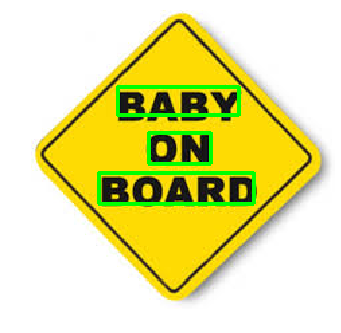

In [0]:
# show the output image
import matplotlib.pyplot as plt
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
cv2.imwrite('helo.jpg',orig)
plt.axis("off")
plt.imshow(orig)

<class 'numpy.ndarray'>


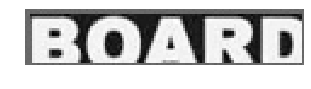

<class 'numpy.ndarray'>


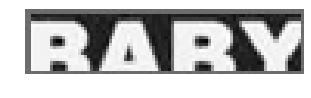

<class 'numpy.ndarray'>


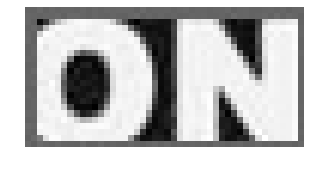

In [0]:
for i in range(len(pic)):
  im = cv2.imread(pic[i],0)
  print(type(im))
  cv2.imwrite(str(i)+'.jpg',im)
  plt.figure(figsize=(5,5))
  plt.axis("off")
  plt.imshow(im)
  plt.show()

In [0]:
#rescaling image enlarging
m=len(pic)
pic1=[]
for i in range(m):
    img=cv2.imread(pic[i])
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(str(i)+'.jpg',img)
    pic1.append(str(i)+'.jpg')

<class 'numpy.ndarray'>


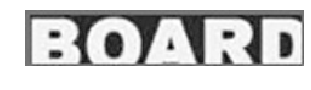

<class 'numpy.ndarray'>


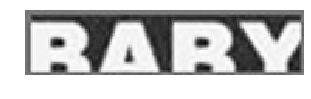

<class 'numpy.ndarray'>


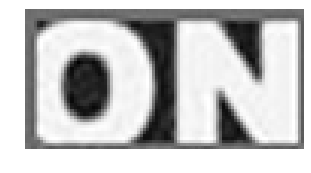

In [0]:
for i in range(len(pic1)):
  im = cv2.imread(pic1[i],0)
  print(type(im))
  cv2.imwrite(str(i)+'.jpg',im)
  plt.figure(figsize=(5,5))
  plt.axis("off")
  plt.imshow(im)
  plt.show()

The text on the image is:	
[<module 'pyocr.tesseract' from '/usr/local/lib/python3.6/dist-packages/pyocr/tesseract.py'>, <module 'pyocr.libtesseract' from '/usr/local/lib/python3.6/dist-packages/pyocr/libtesseract/__init__.py'>]
ON
The translated text is:	
पर


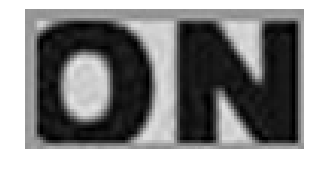

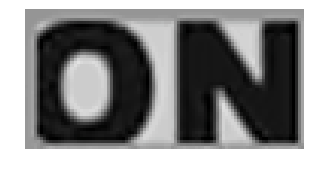

In [0]:
class TextExtract:
 def upload_files():
  uploaded = files.upload()
  return(list(uploaded)[0]) 
 def display_files(f):
  img = cv2.imread(f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(5,5))
  plt.axis("off")
  plt.imshow(img)
  return (img)
 def remove_noise(m):
  dst = cv2.fastNlMeansDenoisingColored(m,None,10,10,7,21)
  plt.figure(figsize=(5,5))
  plt.axis("off")
  plt.imshow(dst)
  cv2.imwrite('hai.jpg',dst)
  return ('hai.jpg')
 def extract_text(f):
  tools = pyocr.get_available_tools()
  print(tools)
  tool = tools[0]
  langs = tool.get_available_languages()
  #print("Available languages: %s" % ", ".join(langs))
  #img = Image.open(f)
  #crop_img = img.crop((0, 15, 15, 0))
  txt = tool.image_to_string(
    Image.open(f),
    lang="eng",
    builder=pyocr.builders.TextBuilder(tesseract_layout=6))
  
  print(txt )
  return txt
 def translate(g):
  from googletrans import Translator
  translator = Translator()
  translator.translate(g)
  a=translator.translate(g, dest='hi')
  return a
 def speak(text):
  from google.colab import output
  js = """
  var synth = window.speechSynthesis
  var utterance= new SpeechSynthesisUtterance()
  utterance.text = %r
  utterance.lang = 'hi-IN'
  utterance.onend = function () { console.log("on end!"); }
  utterance.onerror = function () { console.log("on error!"); }
  utterance.onpause = function () { console.log("on pause"); }
  utterance.onresume = function () { console.log("on resume"); }
  utterance.onstart = function () { console.log("on start"); }
  synth.cancel();
  synth.speak( utterance);
  var r = setInterval(function () {
  console.log(synth.speaking);
  if (!synth.speaking) clearInterval(r);
  else synth.resume();
  }, 14000);
            
  """ % text.replace('-',' ')
  output.eval_js(js)  
T=TextExtract
#s=T.upload_files()
s='2.jpg'
t=T.display_files(s)
j=T.remove_noise(t)
print("The text on the image is:\t")
p=T.extract_text(j)
print("The translated text is:\t")
d=T.translate(p)
print(d.text)
T.speak(d.text)  